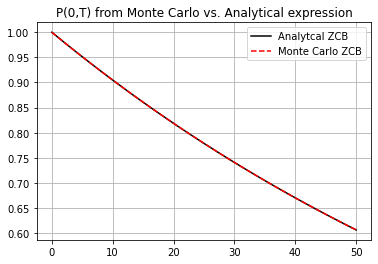

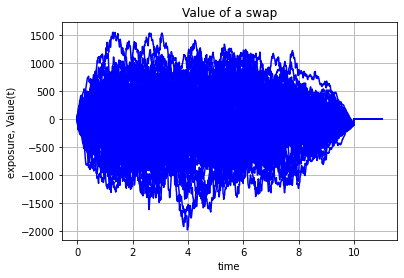

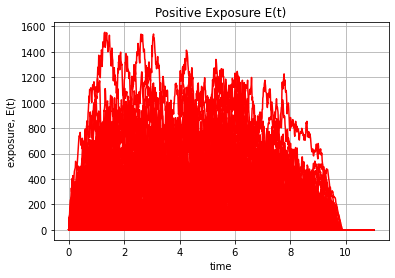

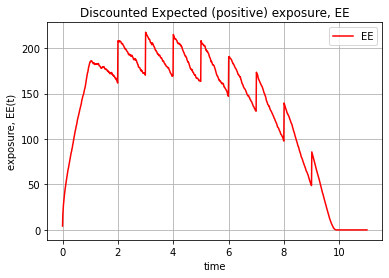

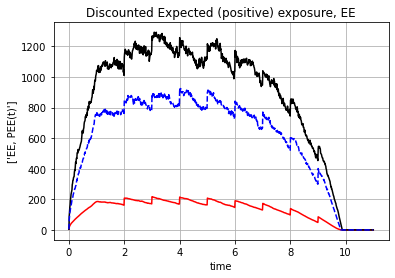

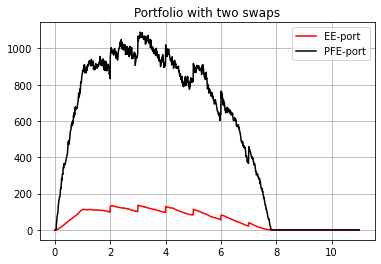

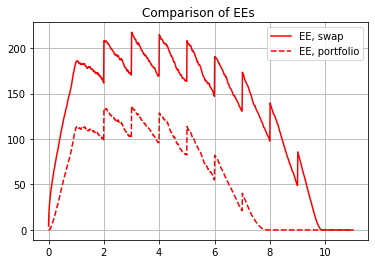

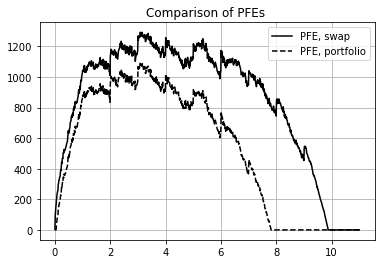

In [5]:
import numpy as np
import enum 
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate as integrate
import warnings
warnings.filterwarnings('ignore')

# This class defines puts and calls
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0

def GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta):    
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    #theta = lambda t: 0.1 +t -t
    #print("changed theta")
    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R}
    return paths

def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    #print("CHANGED THETA")
    return theta #lambda t: 0.1+t-t
    
    #inputs(mean reversion, volatility, discount func at T, T1,t2 are start & end time)
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1 #time
    zGrid = np.linspace(0.0,tau,250) #grid for intergral 
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0) #func for b
    theta = HW_theta(lambd,eta,P0T)  
    #We perform trapezoidal intergration over func tetha over b_r
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    n = np.size(rT1) #it gives 1d array represent forward int. rate at time t1)
        
#If T1 is greater than or equal to T2, then the function returns an array of ones of the same size as rT1.
#This corresponds to the case where the maturity of the bond is before or at the beginning of the bond, 
#which implies that the bond has already matured and its value is equal to one.
    if T1<T2:
        B_r = HW_B(lambd,eta,T1,T2)
        A_r = HW_A(lambd,eta,P0T,T1,T2)
        return np.exp(A_r + B_r *rT1) #Under HW model
    else:
        return np.ones([n])


def HWMean_r(P0T,lambd,eta,T):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd,eta,P0T)
    zGrid = np.linspace(0.0,T,2500)
    #temp which calculates a term that appears in the formula for the mean of the short rate process
    temp =lambda z: theta(z) * np.exp(-lambd*(T-z))
    #to calculate the mean of the short rate process by integrating the function temp over the time grid zGrid
    r_mean = r0*np.exp(-lambd*T) + lambd * integrate.trapz(temp(zGrid),zGrid)
    return r_mean

# Calculates the initial interest rate as r_0
def HW_r_0(P0T,lambd,eta):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0

#Calculating the mean of the forward 
def HW_Mu_FrwdMeasure(P0T,lambd,eta,T):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt) #calculate forward rate
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001) #int. rate
    theta = HW_theta(lambd,eta,P0T)
    zGrid = np.linspace(0.0,T,500)
    # tetha hat function for the change in volatility due to the passage of time
    theta_hat =lambda t,T:  theta(t) + eta*eta / lambd *1.0/lambd * (np.exp(-lambd*(T-t))-1.0)
    temp =lambda z: theta_hat(z,T) * np.exp(-lambd*(T-z))
    #Finally it uses the integrate.trapz function to numerically integrate the integrand and obtain the mean of the forward measure.
    r_mean = r0*np.exp(-lambd*T) + lambd * integrate.trapz(temp(zGrid),zGrid)
    return r_mean

#Calculating variance of r in HW (mean,volatility & time)
def HWVar_r(lambd,eta,T):
    return eta*eta/(2.0*lambd) *( 1.0-np.exp(-2.0*lambd *T))

# Calculate PDF
def HWDensity(P0T,lambd,eta,T):
    r_mean = HWMean_r(P0T,lambd,eta,T)
    r_var = HWVar_r(lambd,eta,T)
    #x represents the interest rate value at which the density function is evaluated
    return lambda x: st.norm.pdf(x,r_mean,np.sqrt(r_var))

def HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,P0T,lambd,eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

#n is 1 then the swap has only one payment period, and the function sets the ti_grid array to contain the start and maturity times
    if n == 1:
        ti_grid =np.array([Ti,Tm])
    #n is greater than 1 function then calculates the time between payments (tau) as the difference between the second and first elements of the ti_grid array
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    # if there exists any previous swap start date Ti before the current valuation date t and if so, selects the most recent one as the new Ti. 
    # It does this by first finding all the ti values in ti_grid that are less than t and storing them in the prevTi array. 
    #If prevTi is not empty (i.e. there exists at least one ti value less than t), the last element of prevTi, which is the most recent swap start date before t, is selected as the new Ti.
    #For example, suppose ti_grid is [1, 2, 3, 4, 5], t is 3.5, and Ti is initially 2. 
    #Then, prevTi would be [2] since it is the only value in ti_grid less than t. The last element of prevTi, which is 2, would then be selected as the new Ti.
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    # ti_grid is grid of swap payment times
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    #all elements set to zero, and its size is equal to the number of elements in the r_t array
    temp= np.zeros(np.size(r_t));
    
    #Ti price of ZCB at maturtiy
    P_t_TiLambda = lambda Ti : HW_ZCB(lambd,eta,P0T,t,Ti,r_t)
    
    #ti_grid is swap payment schedule & now we will calculates the sum of the PV of the forward Libor rates over the period from Ti to Tm 
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
    #tau is fixed payer & ti is current time
    #P_t_TiLambda is a function that calculates the zero-coupon bond price at time t for maturity Ti and given the current short-term interest rates r_t using HW.
            temp = temp + tau * P_t_TiLambda(ti) # sum of temp represents the present value of the floating payments of the swap from Ti to Tm.
            
    P_t_Ti = P_t_TiLambda(Ti) # PV of the ZCB with maturity Ti
    P_t_Tm = P_t_TiLambda(Tm) # PV of the ZCB with maturity Tm
    
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional

def mainCalculation():
    #MCS
    NoOfPaths = 2000
    NoOfSteps = 1000
    lambd     = 0.5  #HW parameter
    eta       = 0.03 #HW parameter
    notional  = 10000.0 
    notional2 = 10000.0
    #We have 2 level for PFE
    alpha     = 0.99
    alpha2     = 0.95
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.01*T) #Specify yeild curve
    r0 = HW_r_0(P0T,lambd,eta) #initial int. rate
    
    # We compare ZCB from the Market comparing ZCB from model
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)
    
    Exact = np.zeros([N,1])
    Proxy= np.zeros ([N,1])
    for i,Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd,eta,P0T,0.0,Ti,r0)
        Exact[i] = P0T(Ti)
        
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid,Exact,'-k')
    plt.plot(Tgrid,Proxy,'--r')
    plt.legend(["Analytcal ZCB","Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')
    
    
    # Here we simulate the exposure profiles for a swap, using the HW model    
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 10.0 # end date of the swap 
    n = 10    # number of payments between Ti and Tm
    
    paths= GeneratePathsHWEuler(NoOfPaths,NoOfSteps,Tm+1.0 ,P0T, lambd, eta) #We are generating MC paths for 11 years
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1]-[0]
    
    # Here we compare the price of an option on a ZCB from Monte Carlo and Analytical expression    
    M_t = np.zeros([NoOfPaths,NoOfSteps])
            
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt) #Money saving account
        
    # Portfolio without netting    
    Value= np.zeros([NoOfPaths,NoOfSteps+1])
    E  = np.zeros([NoOfPaths,NoOfSteps+1])
    EE = np.zeros([NoOfSteps+1])
    PFE = np.zeros([NoOfSteps+1])  #Confidence level of 1% i.e 0.99
    PFE2 = np.zeros([NoOfSteps+1]) #Confidence level of 5% i.e 0.95
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        #First we calculate value of a swap
        V = HW_SwapPrice(OptionTypeSwap.PAYER,notional,K,timeGrid[idx],Ti,Tm,n,r[:,idx],P0T,lambd,eta)
        Value[:,idx] = V  
        E[:,idx] = np.maximum(V,0.0) #positive exposure
        EE[idx] = np.mean(E[:,idx]/M_t[:,idx]) #discounted expected exposure
        PFE[idx] = np.quantile(E[:,idx],alpha)
        PFE2[idx] = np.quantile(E[:,idx],alpha2)
    
    # Portfolio with netting    
    ValuePort = np.zeros([NoOfPaths,NoOfSteps+1])
    EPort  = np.zeros([NoOfPaths,NoOfSteps+1])
    EEPort = np.zeros([NoOfSteps+1])
    PFEPort = np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        #Now we are defining for 2 swap receiver & payer
        Swap1 = HW_SwapPrice(OptionTypeSwap.PAYER,notional,K,timeGrid[idx],Ti,Tm,n,r[:,idx],P0T,lambd,eta)
        Swap2 = HW_SwapPrice(OptionTypeSwap.RECEIVER,notional2,0.0,timeGrid[idx],Tm-2.0*(Tm-Ti)/n,Tm,1,r[:,idx],P0T,lambd,eta)
        
        #We define a portfolio at every time ti with a portfolio
        VPort = Swap1 + Swap2
        ValuePort[:,idx] = VPort #Store the values
        EPort[:,idx] = np.maximum(VPort,0.0) #We calculate the positive exposures at given time ti
        EEPort[idx] = np.mean(EPort[:,idx]/M_t[:,idx]) #discounting EE from portfolio
        PFEPort[idx] = np.quantile(EPort[:,idx],alpha)
    
    plt.figure(2)
    plt.plot(timeGrid,Value[0:100,:].transpose(),'b')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, Value(t)')
    plt.title('Value of a swap')

    plt.figure(3)
    plt.plot(timeGrid,E[0:100,:].transpose(),'r')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, E(t)')
    plt.title('Positive Exposure E(t)')
    
    plt.figure(4)
    plt.plot(timeGrid,EE,'r')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, EE(t)')
    plt.title('Discounted Expected (positive) exposure, EE')
    plt.legend(['EE','PFE'])
    
    plt.figure(5)
    plt.plot(timeGrid,EE,'r')
    plt.plot(timeGrid,PFE,'k')
    plt.plot(timeGrid,PFE2,'--b')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel(['EE, PEE(t)'])
    plt.title('Discounted Expected (positive) exposure, EE')
    
    plt.figure(6)
    plt.plot(timeGrid,EEPort,'r')
    plt.plot(timeGrid,PFEPort,'k')
    plt.grid()
    plt.title('Portfolio with two swaps')
    plt.legend(['EE-port','PFE-port'])
    
    plt.figure(7)
    plt.plot(timeGrid,EE,'r')
    plt.plot(timeGrid,EEPort,'--r')
    plt.grid()
    plt.title('Comparison of EEs ')
    plt.legend(['EE, swap','EE, portfolio'])
    
    plt.figure(8)
    plt.plot(timeGrid,PFE,'k')
    plt.plot(timeGrid,PFEPort,'--k')
    plt.grid()
    plt.title('Comparison of PFEs ')
    plt.legend(['PFE, swap','PFE, portfolio'])
    
mainCalculation()